Knjižnice

In [1]:
import csv
from csv import DictReader
import re
import matplotlib
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import numpy as np
import sys

Branje podatkov

In [2]:
reader = DictReader(open('podatki/min_place.csv', 'rt', encoding='utf-8'))

leto_min_placa = dict()

for row in reader:
    leto_min_placa[row["Leto"]] = row["Placa"];

print(leto_min_placa)

{'2010': '734.15', '2011': '748.10', '2012': '763.06', '2013': '783.66', '2014': '789.15', '2015': '790.73', '2016': '790.73', '2017': '804.96', '2018': '842.79', '2019': '886.63', '2020': '940.58', '2021': '1024.24'}


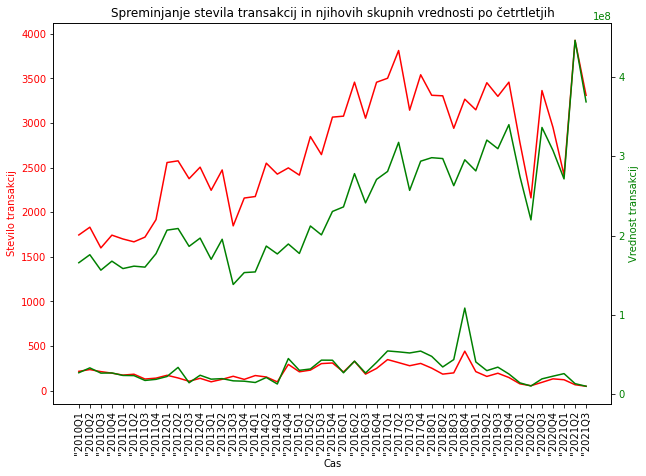

In [3]:

reader = DictReader(open('podatki/st_in_vrednost_nepremicnin.csv', 'rt', encoding='utf-8'))

tabela_nepr = dict()

for col in reader.fieldnames:
    #print(col)
    #print("\n----------------------------------\n")
    tabela_nepr[col] = []
    for row in reader:
        #print(row)
        #print("\n----------------------------------\n")
        tabela_nepr[col].append(row[col])
    reader = DictReader(open('podatki/st_in_vrednost_nepremicnin.csv', 'rt', encoding='utf-8'))

replacer = {'\"': '', '\n': ''}
matrika = np.empty([1,95])
f = open("podatki/st_in_vrednost_nepremicnin.csv", "r")
for x in f:
    for key, value in replacer.items():
        vrstica = [s.replace(key, value) for s in x.split(",")]
    matrika = np.vstack((matrika,vrstica))
matrika = matrika[1::]

xVrednosti = matrika[:1:]
xVrednosti = xVrednosti.ravel()
xVrednosti = xVrednosti[1::]
xVrednosti = xVrednosti[::2]
pom = ["a"]
for vrednost in xVrednosti:
    pom = np.vstack((pom,vrednost.split(" ")[0]))
xVrednosti = pom[1::]
xVrednosti = xVrednosti.ravel()

stare = matrika[2:3:]
nove = matrika[5:6:]

stare = stare.ravel()
nove = nove.ravel()

stare = stare[1::]
nove = nove[1::]

stare = stare.astype(int)
nove = nove.astype(int)

stareTransakcije = stare[::2]
noveTransakcije = nove[::2]
stareVrednost = stare[1::2]
noveVrednost = nove[1::2]


fig, ax = plt.subplots(figsize=(10,7))
ax.set_title("Spreminjanje stevila transakcij in njihovih skupnih vrednosti po četrtletjih")
ax.tick_params('x', labelrotation=90)
ax.set_xlabel('Cas')
ax.set_ylabel('Stevilo transakcij', color='red')
# Plot linear sequence, and set tick labels to the same color
ax.plot(xVrednosti,stareTransakcije, color='red')
ax.plot(noveTransakcije, color='red')
ax.tick_params(axis='y', labelcolor='red')

# Generate a new Axes instance, on the twin-X axes (same position)
ax2 = ax.twinx()

# Plot exponential sequence, set scale to logarithmic and change tick color
ax2.set_ylabel('Vrednost transakcij', color='green')
ax2.plot(stareVrednost, color='green')
ax2.plot(noveVrednost, color='green')
ax2.tick_params(axis='y', labelcolor='green')


plt.show()

In [4]:
reader = DictReader(open('podatki/povp_place.csv', 'rt'))

meseci, bruto, bruto3, neto, neto3 = [],[],[],[],[]



for row in reader:
    meseci.append(row["MESEC"])
    bruto.append(row["Bruto plaèa Plaèa za mesec [EUR]"])
    bruto3.append(row["Bruto plaèa Plaèa za tromeseèje [EUR]"])
    neto.append(row["Neto plaèa Plaèa za mesec [EUR]"])
    neto3.append(row["Neto plaèa Plaèa za tromeseèje [EUR]"])

povp_place = np.array([meseci,bruto,bruto3,neto,neto3])


In [5]:
#!!!!!!PAZI TABELA IMA VREDNOSTI V STRING FORMATU, NAREDI PRETVORBO ČE JO RABIŠ!!!!!!!!!!


#primer uporabe... stolpci tabele : meseci, bruto, povp zadnjih 3 bruto, neto, povp zadnjih 3 neto
for placa in povp_place[1,:3]: #bruto place za prve 3 vnose
    print(placa)

#koliko je placa specificen datum
msk = povp_place[0] == "2014M08"
povp_place[:,msk] #izpisi vse

1539.93
1525.86
1531.61


array([['2014M08'],
       ['1522.25'],
       ['1530.00'],
       ['996.39'],
       ['1000.58']], dtype='<U7')

In [6]:

#Podatki o katera občina pripada kateri regiji
obalnokraška = set(("ANKARAN", "DIVAČA", "HRPELJE-KOZINA", "IZOLA", "KOMEN", "KOPER", "PIRAN", "SNEŽANA"))
primorskonotranjska = set(("BLOKE", "CERKNICA", "ILIRSKA BISTRICA", "LOŠKA DOLINA", "PIVKA", "POSTOJNA"))
goriška = set(("AJDOVŠČINA", "BOVEC", "BRDA", "CERKNO", "IDRIJA", "KANAL", "KOBARID", "MIREN-KOSTANJEVICA", "NOVA GORICA", "REBČE-VOGRSKO", "ŠEMPETER-VRTOJBA", "TOLMIN", "VIPAVA"))
gorenjska = set(("BLED", "BOHINJ", "CERKLJE NA GORENJSKEM", "GORENJA VAS-POLJANE", "GORJE", "JESENICE", "JEZERSKO", "KRANJ", "KRANJSKA GORA", "NAKLO", "PREDDVOR", "RADOVLJICA", "ŠENČUR", "ŠKOFJA LOKA", "TRŽIČ", "ŽELEZNIKI", "ŽIRI", "ŽIROVNICA"))
osrednjeslovenska = set(("BOROVNICA", "BRZOVICA", "DOBREPOLJE", "DOBROVA-POLHOV GRADEC", "DOL PRI LJUBLJANI", "DOMŽALE", "GROSUPLJE", "HORJUL", "Ig", "IVANČNA GORICA", "KAMNIK", "KOMENDA", "LJUBLJANA", "LOG-DRAGOMER", "LOGATEC", "LUKOVICA", "MEDVODE", "MENGEŠ", "MORAVČE", "ŠKOFLJICA", "ŠMARTNO PRI LITIJI", "TRZIN", "VELIKE LAŠČE", "VODICE", "VRHNIKA"))
zasavska = set(("HRASTNIK", "LITIJA", "TRBOVLJE", "ZAGORJE OB SAVI"))
jugovzhodnaslovenija = set(("ČRNOMELJ", "DOLENJSKE TOPLICE", "KOČEVJE", "KOSTEL", "LOŠKI POTOK", "METLIKA", "MIRNA", "MIRNA PEČ", "MOKRONOG-TREBELNO", "NOVO MESTO", "OSILNICA", "RIBNICA", "SEMIČ", "SODRAŽICA", "STRAŽA", "ŠENTJERNEJ", "ŠENTRUPERT", "ŠKOCJAN", "ŠMARJEŠKE TOPLICE", "TREBNJE", "ŽUŽEMBERK"))
posavska = set(("BISTRICA OB SOTLI", "BREŽICE", "KOSTANJEVICA NA KRKI", "KRŠKO", "RADEČE", "SEVNICA"))
savinjska = set(("BRASLOVČE", "CELJE", "DOBJE", "DOBRNA", "GORNJI GRAD", "KOZJE", "LAŠKO", "LJUBNO", "LUČE", "MOZIRJE", "NAZARJE", "PODČETRTEK", "POLZELA", "PREBOLD", "REČICA PRI SAVINJI", "ROGAŠKA SLATINA", "ROGATEC", "SLOVENSKE KONJICE", "SOLČAVA", "ŠENTJUR", "ŠMARJE PRI JELŠAH", "ŠMARTNO OB PAKI", "ŠOŠTANJ", "ŠTORE", "TABOR", "VELENJE", "VITANJE", "VOJNIK", "VRANSKO", "ZREČE", "ŽALEC"))
krorška = set(("ČRNA NA KOROŠKEM", "DRAVOGRAD", "MEŽICA", "MOSLINJA", "MUTA", "PODVELKA", "PREVALJE", "RADLJE OB DRAVI", "RAVNE NA KOROŠKEM", "RIBNICA NA POHORJU", "SLOVENJ GRADEC", "VUZENICA"))
podravska = set(("BENEDIKT", "CERKVENJAK", "CIRKULANE", "DESTRNIK", "DORNAVA", "DUPLEK", "GORIŠNICA", "HAJDINA", "HOČE-SLIVNICA", "JURŠINCI", "KIDRIČEVO", "KUNGOTA", "LENART", "LOVRENC NA POHORJU", "MAJŠPERK", "MAKOLE", "MARIBOR", "MARKOVCI", "MIKLAVŽ NA DRAVSKEM POLJU", "OPLOTNICA", "ORMOŽ", "PESNICA", "PODLEHNIK", "POLJČANE", "PTUJ", "RAČE-FRAM", "RUŠE", "SELNICA OB DRAVI", "SLOVENSKA BISTRICA", "SREDIŠČE OB DRAVI", "STARŠE", "SVETA ANA", "SV. TROJICA V SLOV. GORICAH", "SVETI ANDRAŽ V SLOV. GORICAH", "SVETI JURIJ V SLOV. GORICAH", "SVETI TOMAŽ", "ŠENTILJ", "TRNOVKSA VAS", "VIDEM", "ZAVRČ", "ŽETALE"))
pomurska = set(("APAČE", "BELTINCI", "CANKOVA", "ČRENŠOVCI", "DOBROVNIK", "GORNJA RADGONA", "GORNJI PETROVCI", "GRAD", "HODOŠ", "KOBILJE", "KRIŽEVCI", "KUZMA", "LENDAVA", "LJUTOMER", "MORAVSKE TOPLICE", "MURSKA SOBOTA", "ODRANCI", "PUCONCI", "RADENCI", "RAZKRIŽJE", "ROGAŠOVCI", "SVETI JURIJ OB ŠČAVNICI", "ŠALOVCI", "TIŠINA", "TURNIŠČE", "VELIKA POLANA", "VERŽEJ"))

In [7]:
def EtnRead(year, tip, header = None): #header je če nas zanima le header vrstica, določene ETN datoteke
    if tip not in ('posli','delistavb','zemljisca'): #table get check
        print(f'Unknown file name "{tip}";\nAllowed : "posli" , "delistavb", "zemljisca"')
        return None

    if not (2006 < year < 2023):  #year range check
        print(f'Incorrect year: {year}\nRange is [2007,2022]')
        return None
                            #index stolpca opombe, ki ga zbrišemo saj nam opomba lahko bloata np table
                            #index opombe v csvju : posli = zemljisca = 9 , delistavb = 27
                            ####če je treba preskočiti še kakšen stolpec, dodaj v pravi list index stolpca###
    indexi = [9]            
    if tip == 'delistavb':
        indexi = [27]
        
    if tip == 'zemljisca':
        pass        #preskoci


    data_path = f'podatki/ETN_SLO_CSV_A_KUP/ETN_SLO_KUP_{year}_20220326/ETN_SLO_KUP_{year}_{tip}_20220326.csv'

    with open(data_path,encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile, delimiter=';')
        data = []

        head = next(reader,None) #skip header

        if header:
            return head #vrne header row

        for row in reader:
            try:
                for i in indexi:
                    row[i] = ""
            except Exception as e:
                print(row)
                print(e)
                return
            data.append(row)
    
    return np.array(data)


In [8]:

#zemljisca2010 = EtnRead(2010,'zemljisca')
posli2010 = EtnRead(2010,'posli')
delistavb2010 = EtnRead(2010,'delistavb')


In [9]:
#_ =[print(x) for x in enumerate(EtnRead(2010,'zemljisca',True))] 
_ =[print(x) for x in enumerate(EtnRead(2010,'delistavb',True))]


(0, 'ID Posla')
(1, 'Šifra KO')
(2, 'Ime KO')
(3, 'Občina')
(4, 'Številka stavbe')
(5, 'Številka dela stavbe')
(6, 'Parcelna številka za geolokacijo')
(7, 'Interna oznaka dela stavbe')
(8, 'Evidentiranost dela stavbe')
(9, 'Naselje')
(10, 'Ulica')
(11, 'Hišna številka')
(12, 'Dodatek HŠ')
(13, 'Številka stanovanja ali poslovnega prostora')
(14, 'Vrsta dela stavbe')
(15, 'Leto izgradnje dela stavbe')
(16, 'Stavba je dokončana')
(17, 'Gradbena faza')
(18, 'Novogradnja')
(19, 'Prodana površina')
(20, 'Prodani delež dela stavbe')
(21, 'Prodana površina dela stavbe')
(22, 'Prodana uporabna površina dela stavbe')
(23, 'Nadstropje dela stavbe')
(24, 'Število zunanjih parkirnih mest')
(25, 'Atrij')
(26, 'Površina atrija')
(27, 'Opombe o nepremičnini')
(28, 'Dejanska raba dela stavbe')
(29, 'Lega dela stavbe v stavbi')
(30, 'Število sob')
(31, 'Površina dela stavbe')
(32, 'Uporabna površina')
(33, 'Prostori dela stavbe')
(34, 'Pogodbena cena dela stavbe')
(35, 'Stopnja DDV dela stavbe')


In [10]:
def getDictPosli(posliData):
    dict_posli = {}
    for row in posliData:
        if row[4] == '' or row[4] == '0':  # cene 0 smiselne?
            continue
        dict_posli[row[0]] = float(row[4].replace(",","."))
    return dict_posli

In [11]:
def getDictStavbe(delistavbData):
    dict_stavbe = {}
    for row in delistavbData:
        if row[14] not in ('1','2'): #če stavba ni stanovalska hiša ali stanovanje jo preskoči
            continue

        povrsina = row[19] #stolpec 'Prodana površina'

        
        if povrsina == '': #ce ni podatka o povrsini
            continue

        povrsina = float(povrsina.replace(",",".")) 
        
        if povrsina == 0: #ce je povrsina 0
            continue

        obcina = row[3]
        
        dict_stavbe[row[0]] = (povrsina, obcina) 
        
        #(row[19],row[20],row[21],row[22])
    return dict_stavbe

In [12]:
def generateCenaNaMeter(dictStavbe,dictPosli):
    kljuci = dictStavbe.keys()
    naMeter = []
    for kljuc in kljuci:
        if kljuc not in dictPosli:
            continue
        cena = dictPosli[kljuc]
        povrsina = dictStavbe[kljuc][0] # [0] nam da povrsino, [1] bi dal obcino
        naMeter.append(cena/povrsina)
    return sum(naMeter) / len(naMeter)

In [13]:
def getAllCnM(): #get all cena na meter
    cenaNaMeter = dict()
    for i in range(2007,2023):
        
        dictPosli = getDictPosli(EtnRead(i,'posli'))
        dictStavbe = getDictStavbe(EtnRead(i,'delistavb'))
        naMeter = generateCenaNaMeter(dictStavbe,dictPosli)
        cenaNaMeter[i] = naMeter
        print(f"Leto {i} cena na meter: {naMeter}")
    return cenaNaMeter
    

In [14]:
cenaNaMeter = getAllCnM()

Leto 2007 cena na meter: 1589.7148609612602
Leto 2008 cena na meter: 4837.010356537396
Leto 2009 cena na meter: 4159.273340415848
Leto 2010 cena na meter: 3743.4479749743177
Leto 2011 cena na meter: 2775.8632679091434
Leto 2012 cena na meter: 3546.1035434833743
Leto 2013 cena na meter: 1886.054125450965
Leto 2014 cena na meter: 1300.185275085118
Leto 2015 cena na meter: 1168.9791923411492
Leto 2016 cena na meter: 1147.7294070988437
Leto 2017 cena na meter: 1150.2374186793254
Leto 2018 cena na meter: 1244.5424858400695
Leto 2019 cena na meter: 1296.6778445823497
Leto 2020 cena na meter: 1423.104298621578
Leto 2021 cena na meter: 1560.6362667229089
Leto 2022 cena na meter: 2628.8502865434043


Analiza podatkov

In [15]:
allDataLenVsi = []
manka19Vsi = []
manka22Vsi = []
mankaObaVsi = []

for i in range(2007,2023):
    deliStavbData = EtnRead(i,'delistavb')

    #zakomentiraj spodnji dve vrstici če te zanimajo vsi podatki
    # in ne samo podatki o stanovanjih in stanovanskih hišah
    mask = np.logical_or(deliStavbData[:,14] == '1',deliStavbData[:,14] == '2')
    deliStavbData = deliStavbData[mask,:]

    allDataLen = deliStavbData.shape[0]
    manka19 = sum(deliStavbData[:,19] == '') / allDataLen
    manka22 = sum(deliStavbData[:,22] == '') / allDataLen
    mankaOba = sum(np.logical_and(deliStavbData[:,19] == '', deliStavbData[:,22] == '')) / allDataLen

    del deliStavbData

    allDataLenVsi.append(allDataLen)
    manka19Vsi.append(manka19)
    manka22Vsi.append(manka22)
    mankaObaVsi.append(mankaOba)


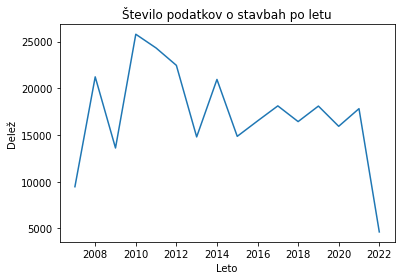

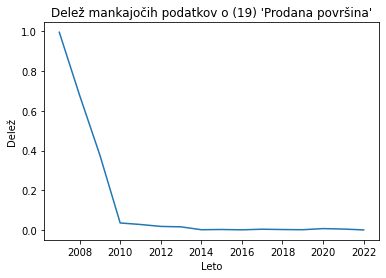

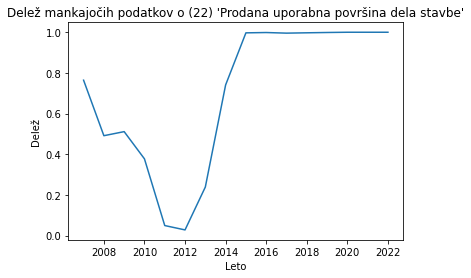

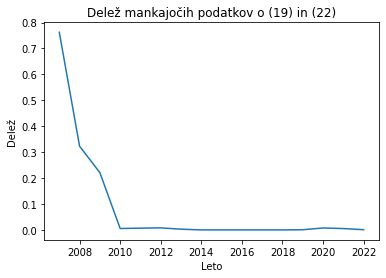

In [16]:
plt.plot(range(2007,2023),allDataLenVsi)
plt.xlabel("Leto")
plt.ylabel("Delež")
plt.title("Število podatkov o stavbah po letu")
plt.show()


plt.plot(range(2007,2023),manka19Vsi)
plt.xlabel("Leto")
plt.ylabel("Delež")
plt.title("Delež mankajočih podatkov o (19) 'Prodana površina'")
plt.show()

plt.plot(range(2007,2023),manka22Vsi)
plt.xlabel("Leto")
plt.ylabel("Delež")
plt.title("Delež mankajočih podatkov o (22) 'Prodana uporabna površina dela stavbe'")
plt.show()

plt.plot(range(2007,2023),mankaObaVsi)
plt.xlabel("Leto")
plt.ylabel("Delež")
plt.title("Delež mankajočih podatkov o (19) in (22)")
plt.show()

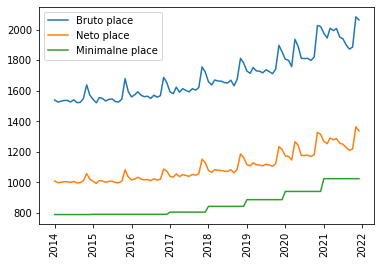

In [17]:
from datetime import datetime

seznam = []
for leto in range(2014,2022):
    for mesec in range(1,13):
        seznam.append(datetime.strptime(str(leto)+"-"+str(mesec), '%Y-%m'))


matrika = np.array([[seznam,bruto,neto]], dtype = object)
minPlace =[]
for key in leto_min_placa.keys():
    if int(key) >=2014:
        minPlace.append(leto_min_placa[key])

minPlace = np.repeat(minPlace, 12)
minPlace = np. reshape(minPlace.astype(float), -1)
  
bruto1 =  np. reshape(matrika[:,1].astype(float), -1)
neto1 = np. reshape(matrika[:,2].astype(float), -1)
y = np. reshape(matrika[:,0].astype(datetime), -1)

plt.plot(y,bruto1, label="Bruto place")
plt.plot(y,neto1, label="Neto place")
plt.plot(y,minPlace,label ="Minimalne place")

plt.legend()
plt.xticks(rotation=90)
plt.show()

#print(y)

In [18]:
stolpci = tabela_nepr.keys() #vsi stolpci

for key in stolpci:
    print(tabela_nepr[key])#prvi stolpec, pove kaj pomeni posamezna vrstica
    break
vrstica = tabela_nepr["DWELLINGS"] #prvi stolpec, pove kaj pomeni posamezna vrstica
print(vrstica) #izpiši prvi stolpec

zanimiva_vr = vrstica.index("1 Dwellings - TOTAL")  #pridobi vrstico, ki te zanima

print(zanimiva_vr)


['1 Dwellings - TOTAL', '1.1 Newly built dwellings', '1.1.1 Newly built flats', '1.1.2 Newly built family houses', '1.2 Existing dwellings', '1.2.1 Existing flats Slovenia', '1.2.2 Existing family houses']
['1 Dwellings - TOTAL', '1.1 Newly built dwellings', '1.1.1 Newly built flats', '1.1.2 Newly built family houses', '1.2 Existing dwellings', '1.2.1 Existing flats Slovenia', '1.2.2 Existing family houses']
0


In [19]:
for key in tabela_nepr.keys():
    if re.search("Number of transactions$",key): #primer za iteracijo po # transakcij
        print(key)
        print(tabela_nepr[key][zanimiva_vr]) 

2010Q1 Number of transactions
1961
2010Q2 Number of transactions
2068
2010Q3 Number of transactions
1813
2010Q4 Number of transactions
1939
2011Q1 Number of transactions
1874
2011Q2 Number of transactions
1852
2011Q3 Number of transactions
1851
2011Q4 Number of transactions
2057
2012Q1 Number of transactions
2729
2012Q2 Number of transactions
2718
2012Q3 Number of transactions
2481
2012Q4 Number of transactions
2643
2013Q1 Number of transactions
2345
2013Q2 Number of transactions
2601
2013Q3 Number of transactions
2008
2013Q4 Number of transactions
2285
2014Q1 Number of transactions
2345
2014Q2 Number of transactions
2703
2014Q3 Number of transactions
2525
2014Q4 Number of transactions
2791
2015Q1 Number of transactions
2627
2015Q2 Number of transactions
3078
2015Q3 Number of transactions
2949
2015Q4 Number of transactions
3376
2016Q1 Number of transactions
3286
2016Q2 Number of transactions
3787
2016Q3 Number of transactions
3239
2016Q4 Number of transactions
3706
2017Q1 Number of tra

In [20]:
stTransakcij = {}
stevec = 0

for key in tabela_nepr.keys():
    if re.search("Number of transactions$",key): #primer za iteracijo po # transakcij
        #print(key)
        #print(tabela_nepr[key][zanimiva_vr])
        stTransakcij[key.split(" ")[0]] = int(tabela_nepr[key][zanimiva_vr])

print(stTransakcij)


{'2010Q1': 1961, '2010Q2': 2068, '2010Q3': 1813, '2010Q4': 1939, '2011Q1': 1874, '2011Q2': 1852, '2011Q3': 1851, '2011Q4': 2057, '2012Q1': 2729, '2012Q2': 2718, '2012Q3': 2481, '2012Q4': 2643, '2013Q1': 2345, '2013Q2': 2601, '2013Q3': 2008, '2013Q4': 2285, '2014Q1': 2345, '2014Q2': 2703, '2014Q3': 2525, '2014Q4': 2791, '2015Q1': 2627, '2015Q2': 3078, '2015Q3': 2949, '2015Q4': 3376, '2016Q1': 3286, '2016Q2': 3787, '2016Q3': 3239, '2016Q4': 3706, '2017Q1': 3850, '2017Q2': 4127, '2017Q3': 3423, '2017Q4': 3846, '2018Q1': 3563, '2018Q2': 3490, '2018Q3': 3140, '2018Q4': 3709, '2019Q1': 3361, '2019Q2': 3611, '2019Q3': 3494, '2019Q4': 3605, '2020Q1': 2857, '2020Q2': 2216, '2020Q3': 3457, '2020Q4': 3082, '2021Q1': 2538, '2021Q2': 3993, '2021Q3': 3359}


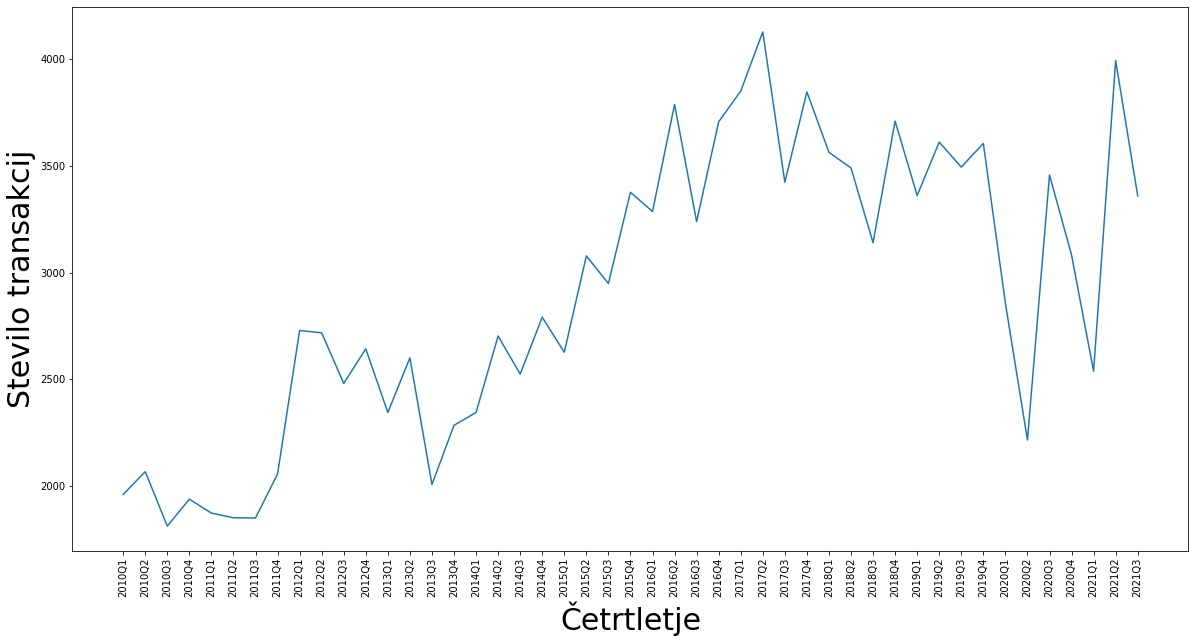

In [21]:
#Stevilo transakcij plot
StTran_items = stTransakcij.items()

x, y = zip(*StTran_items)

plt.figure(figsize=(20,10))
plt.plot(x, y)
plt.rcParams['font.size'] = 14
plt.xticks(rotation=90)
plt.xlabel('Četrtletje', fontsize=30)
plt.ylabel('Stevilo transakcij', fontsize=30)
plt.show()

Random stuff

In [22]:
def sizeof_fmt(num, suffix="B"): #funkcija za formatiranje izpisa velikosti spremenljivk
    for unit in ["", "Ki", "Mi", "Gi", "Ti", "Pi", "Ei", "Zi"]:
        if abs(num) < 1024.0:
            return f"{num:3.1f}{unit}{suffix}"
        num /= 1024.0
    return f"{num:.1f}Yi{suffix}"

#preveri katerih podatkov ne more prebrati 
def checkRAM(ime):
    for i in range(2007,2023):
        try:
            data = EtnRead(i,ime)
            size = sizeof_fmt(sys.getsizeof(data))
            print(f"{i} => {data.dtype}, ram usage: {size}") #preveri tip tabele ie string length
            del data
        except Exception as e:
            print(f"{i} => {e}")  #prikazi katero leto ti vrže (memoryError -> zmankal rama) exception 
            pass

def test():
    print('delistavb')
    checkRAM('delistavb')
    print()

    print('zemljisca')
    checkRAM('zemljisca')
    print()

    print('posli')
    checkRAM('posli')
    
#test()

In [23]:
def _zemljisca():       #fix ce mislis use
    dict_zemljisca = {}
    for row in zemljisca2010:
        if row[10] == '' or int(row[10]) == '0': # če ni površine preskoči
            continue
        if row[5] not in (1,2,3,4): #ce ni primernega tipa za stanovanje oz hišo nas ne zanima
            pass
            #continue
        if "/" in row[8]: # row[8] != 'NP' and row[8] != '6179844811' and row[8] != '': #preveri pomen NP, ali je Ni Podatka ali kaj
            ops = row[8].split("/") 
        else:
            ops = ['1', '1']
        
        if ops[0] == '':
            ops[0] = 1
        if ops[1] == '':
            ops[1] = 1

        prodanDelez = int(ops[0]) / int(ops[1])

        if prodanDelez == 0:
            continue


        povrsinaParcele = float(row[10].replace(",","."))
        if row[0] in dict_zemljisca:
            dict_zemljisca[row[0]]+= povrsinaParcele #* prodanDelez
        else:
            dict_zemljisca[row[0]] = povrsinaParcele #* prodanDelez